In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import random
import cv2

from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Flatten, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization, Dropout, LeakyReLU
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
from keras import activations

from sklearn.preprocessing import MinMaxScaler




from tensorflow.keras import utils
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()


In [61]:
%%time
# # To get the images and labels from file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# To convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# To convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)
labels_names = ["Disturbed Galaxies", "Merging Galaxies", "Round Smooth Galaxies", "In-between Round Smooth Galaxies", "Cigar Shaped Smooth Galaxies",
            "Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies", "Edge-on Galaxies without Bulge", "Edge-on Galaxies with Bulge"]

In [139]:
for name, count in zip(labels_names, np.unique(labels[:,:], axis=0, return_counts=True)[1]):
    print(f"{name}: {count}")

Disturbed Galaxies: 1873
Merging Galaxies: 1423
Round Smooth Galaxies: 2628
In-between Round Smooth Galaxies: 1829
Cigar Shaped Smooth Galaxies: 2043
Barred Spiral Galaxies: 334
Unbarred Tight Spiral Galaxies: 2027
Unbarred Loose Spiral Galaxies: 2645
Edge-on Galaxies without Bulge: 1853
Edge-on Galaxies with Bulge: 1081


In [ ]:
%%time
resized_images = np.zeros((17736, 64, 64, 3), dtype=np.uint8)

# Iteracja po każdym obrazie w oryginalnej tablicy i zmniejszenie go do 64x64
for i in range(images.shape[0]):
    original_image = images[i]
    resized_image = cv2.resize(original_image, (64, 64), interpolation=cv2.INTER_AREA)
    images[i] = resized_image

In [4]:
# with h5py.File('Galaxy10_DECals.h5', 'r') as h5_file:
#     # Odczytaj dane ze zbiorów danych
#     ans_data = h5_file['ans'][:]
#     dec_data = h5_file['dec'][:]
#     images_data = h5_file['images'][:]
#     pxscale_data = h5_file['pxscale'][:]
#     ra_data = h5_file['ra'][:]
#     redshift_data = h5_file['redshift'][:]

# # Tworzenie DataFrame z danymi
# data_dict = {
#     'ans': ans_data,
#     'dec': dec_data,
#     'images': images_data,
#     'pxscale': pxscale_data,
#     'ra': ra_data,
#     'redshift': redshift_data
# }

# df = pd.DataFrame(data_dict)

In [ ]:
%%time
# resize and convertion to grayscale
resized_gray_images = np.zeros((17736, 128, 128), dtype=np.uint8)

# Iteracja po każdym obrazie w oryginalnej tablicy i zmniejszenie go do 64x64
for i in range(images.shape[0]):
    original_image = images[i]
    resized_image = cv2.resize(original_image, (128, 128), interpolation=cv2.INTER_AREA)
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    resized_gray_images[i] = gray_image
    
images = resized_gray_images
del resized_gray_images

CPU times: total: 25.2 s
Wall time: 1min 11s


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


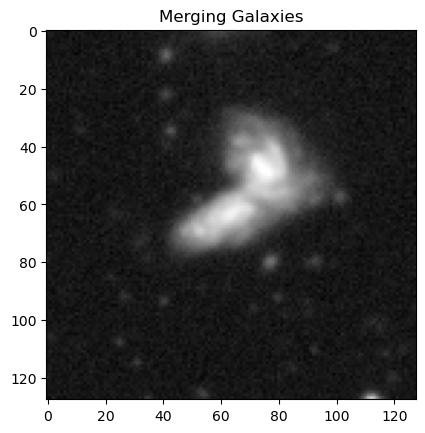

In [141]:
def show_image(index):
    plt.imshow(images[index].astype(np.int16), cmap="gray")
    plt.title(labels_names[np.where(labels[index] == 1)[0][0]])
    print(labels[index])
    plt.show()

show_image(2430)

In [91]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(images.reshape(-1, 128*128))
X_train = X_train.reshape(-1, 128, 128)


In [96]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          loca
    ls().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                        images: 277.1 MiB
                        labels: 692.9 KiB
                 resized_image: 192.1 KiB
                          temp: 64.1 KiB
                    gray_image: 64.1 KiB
                          _i82:  1.4 KiB
                           _i4:  1.2 KiB
                  MinMaxScaler:  1.2 KiB
                           _oh:  1.1 KiB
                           Out:  1.1 KiB


Disturbed Galaxies: 1873
Merging Galaxies: 1423
Round Smooth Galaxies: 2628
In-between Round Smooth Galaxies: 1829
Cigar Shaped Smooth Galaxies: 2043
Barred Spiral Galaxies: 334
Unbarred Tight Spiral Galaxies: 2027
Unbarred Loose Spiral Galaxies: 2645
Edge-on Galaxies without Bulge: 1853
Edge-on Galaxies with Bulge: 1081


In [126]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)